Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Zhongzhi Zhang"
COLLABORATORS = ""

---

# Homework 0: Rootfinding

See the [Rootfinding notebook](https://github.com/cucs-numcomp/numcomp-class/blob/master/Rootfinding.ipynb) for background.
This homework is due Sunday, 2018-02-03.

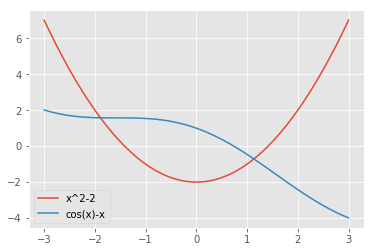

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
np.seterr(divide='raise') # Raise exception on divide by zero

class FDict(dict):
    "A collection of labeled functions"
    def add(self, name):
        def _add(f):
            self[name] = f
        return _add

tests = FDict()

@tests.add('x^2-2') # The labels will be used in plotn
def f(x):
    return x**2 - 2, 2*x

@tests.add('cos(x)-x')
def f(x):
    return np.cos(x) - x, -np.sin(x) - 1

def plotf(f, label=None):
    x = np.linspace(-3, 3)
    return plt.plot(x, f(x)[0], label=label)
    
for name, f in tests.items():
    plotf(f, name)
plt.legend();

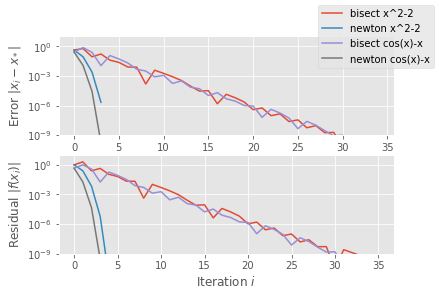

In [2]:
def bisect(f, a, b, tol=1e-10):
    "Iterative (rather than recursive) bisection method"
    fa, fb = f(a)[0], f(b)[0]
    if fa*fb > 0:
        raise ValueError('Interval function does not change sign, may not contain root')
    history = []
    while b-a > tol:
        mid = (a + b)/2.
        fmid = f(mid)[0]
        history.append((mid, fmid))
        if fa*fmid <= 0:
            b, fb = mid, fmid
        else:
            a, fa = mid, fmid
    return np.array(history)

def newton(f, a, b, tol=1e-10):
    """Newton method without a line search
    """
    x = (a + b) / 2
    history = []
    for i in range(100):
        fx, dfx = f(x)
        history.append((x, fx))
        if np.abs(fx) < tol:
            break
        try:
            x -= fx / dfx
        except FloatingPointError:
            break
    return np.array(history)

def plot_conv(tests, methods):
    """Plot the convergence of a group of methods on a dict of test problems"""
    fig = plt.figure()
    axerror = plt.subplot(2,1,1)
    axresid = plt.subplot(2,1,2)
    for name, f in tests.items():
        for method in methods:
            h = method(f, -1, 3)
            label = '{} {}'.format(method.__name__, name)
            axerror.semilogy(np.abs(h[:-1,0] - h[-1,0]), label=label)
            axresid.semilogy(np.abs(h[:,1]))
    axerror.set_ylabel('Error $|x_i - x_*|$')
    axresid.set_ylabel('Residual $|f(x_i)|$')
    axerror.set_ylim(1e-9, 10)
    axresid.set_ylim(1e-9, 10)
    axresid.set_xlabel('Iteration $i$')
    fig.legend();
    
plot_conv(tests, (bisect, newton))

## Monotonic function for which Newton diverges

* A function $f$ is *strictly montonically increasing* if $f(a) < f(b)$ for all $a < b$.  If $f$ is differentiable, this implies $f'(x) > 0$ for all $x$.

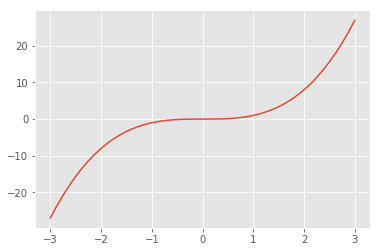

In [62]:
@tests.add('monotonic_diverge')
def f(x):
    """Strictly monotonically increasing function with a simple
    root at x=0 for which Newton's method diverges with initial
    guess x=1.
    
    Remember that the interface requires that this function and
    its derivative be defined.
    """
    # YOUR CODE HERE
    #return (x)**(1/3), 1/(3*x**(0.75))
    return x**3, 3*x**2
    raise NotImplementedError()

plotf(tests['monotonic_diverge']);

In [63]:
def ismonotonic(f):
    x = np.linspace(-5, 5)
    fx = f(x)[0]
    return np.all(fx[1:] > fx[:-1])

def isdivergent(f):
    h = newton(f, -1, 3)
    hx = h[:,0]
    return np.abs(hx[-1]) > np.abs(hx[-2])

assert np.abs(tests['monotonic_diverge'](0)[0]) < 1e-10
assert ismonotonic(tests['monotonic_diverge'])
assert isdivergent(tests['monotonic_diverge'])
print('Tests pass')

AssertionError: 

## Secant method

The secant method is similar to Newton's method, but instead of evaluating $f'(x)$ directly, it uses the approximation
$$ f'(x_i) \approx \frac{f(x_{i} - f(x_{i-1})}{x_i - x_{i-1}} . $$
Implement the secant method by writing code similar to Newton's method, but using this in place of $f'(x_i)$ where it appears in Newton's method.

(1.0, -1.0)


ZeroDivisionError: float division by zero

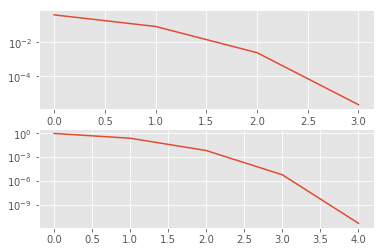

In [72]:
def secant(f, a, b, tol=1e-10):
    "Solve f(x) = 0 using the secant method"
    history = []
    xlast, flast = b, f(b)[0] # We'll use x=b as our last evaluation to initialize
    x = (a + b) / 2           # And start with the midpoint as the current guess
    for i in range(100):
        fx = f(x)[0]
        history.append((x, fx))
        if np.abs(fx) < tol:
            break
        
        print(history[i-1])
        dfx = (history[i][1]-history[i-1][1])/(history[i][0]-history[i-1][0])
        try:
            x -= fx / dfx
        except FloatingPointError:
            break
        # YOUR CODE HERE
        
        
        raise NotImplementedError()
    return np.array(history)

plot_conv(tests, (newton, secant))

In [73]:
assert np.allclose(secant(tests['x^2-2'], -1, 3)[-1],
                   [np.sqrt(2), 0])
print('Tests pass')

(1.0, -1.0)


ZeroDivisionError: float division by zero

## Newton with a line search

Newton's method is often paired with a line search which finds the smallest non-negative integer $k$ such that
$$ |f(x_{n+1})| < |f(x_n)| $$
where
$$ x_{n+1} = x_n - 2^{-k} f(x) / f'(x) . $$
Implement this algorithm by shortening the step until the inequality is satisfied.

In [74]:
def newtonls(f, a, b, tol=1e-10):
    """Newton's method with a line search"""
    x = (a + b) / 2
    history = []
    for i in range(100):
        fx, dfx = f(x)
        history.append((x, fx))
        if np.abs(fx) < tol:
            break
        try:
            # k=-
            x -= (2**(k))(fx / dfx)
        except FloatingPointError:
            break
        # YOUR CODE HERE
        raise NotImplementedError()
    return np.array(history)

In [75]:
assert np.allclose(newtonls(tests['monotonic_diverge'], 0, 2)[-1],
                   [0, 0])

TypeError: 'float' object is not callable

## Accuracy

Find a function $f(x)$ with a root at $x=0$ where bisection and Newton both converge, but Newton has an error of at least $10^{-2} = .01$ even when the residual is smaller than $10^{-10}$.

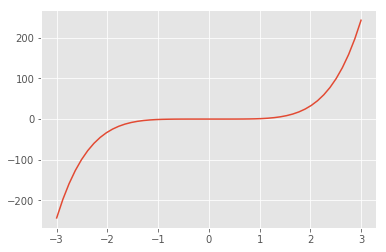

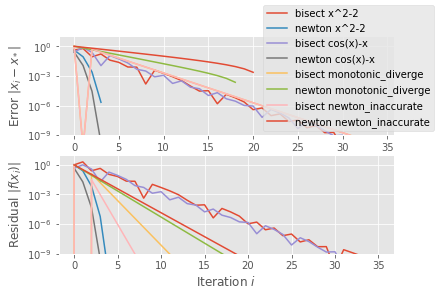

In [76]:
@tests.add('newton_inaccurate')
def f(x):
    # YOUR CODE HERE
    return x**5, 5*x**4
    raise NotImplementedError()
    
plotf(tests['newton_inaccurate'])
plot_conv(tests, (bisect, newton))

In [77]:
h = newton(tests['newton_inaccurate'], -1, 3)
smallresid = np.abs(h[:,1]) < 1e-10
assert np.sometrue(smallresid)
assert np.sometrue(h[smallresid,0] > 1e-2)
print('Tests pass')

AssertionError: 